Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

In [1]:
from random import random, seed
from itertools import product
import numpy as np
from matplotlib import pyplot as plt

from icecream import ic
from tqdm.auto import tqdm # automatic progress bar

## Reproducible Initialization

If you want to get reproducible results, use `rng` (and restart the kernel); for non-reproducible ones, use `np.random`.

In [2]:
UNIVERSE_SIZE = 100_000
NUM_SETS = 10_000
DENSITY = 0.3

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

- `UNIVERSE_SIZE` is the number of items
- `NUM_SETS` is the total number of sets associated to the universe initially
- `DENSITY` is the probability of each item to belong to each set, or also the total cover of the unisverse by each set

In [3]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

- `SETS` is a `<NUM_SETS x UNIVERSE_SIZE>` vector indicating for each set whether each element of the universe belong to the set or not; `SETS` are randomly generated but in order to ensure UNIVERSE completeness, the loop check if some elements are not present in any set in order to add it to a random one in that case;
- `COSTS` is a `<NUM_SETS>` vector indicating the total cost of each set;

Finally, we also define ITERATIONS hyperparameter

In [11]:
ITERATIONS = 10_000

## Helper Functions

In [12]:
def phenotype(solution):
    """Returns the phenotype of the solution"""
    return np.logical_or.reduce(SETS[solution]) # LOGICAL OR OF ALL CHOSEN SETS ITEMS: presence of all items in this solution

def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(phenotype(solution))

def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

## Have Fun!

A first trivial solution includes all sets in the "*set of subsets*"

In [13]:
# A dumb solution of "all" sets
solution = np.full(NUM_SETS, True)
ic(solution);
ic(valid(solution), cost(solution));

ic| solution: array([ True,  True,  True, ...,  True,  True,  True])
ic| valid(solution): np.True_
    cost(solution): np.float64(841093912.0743632)


Another solution includes half of the sets, but the number of subsets is very high so there is still complete coverage for most cases (maybe all).

In [14]:
# A random solution with random 50% of the sets
solution = rng.random(NUM_SETS) < 0.5
ic(solution);
ic(valid(solution), cost(solution));

ic| solution: array([ True, False, False, ..., False, False,  True])
ic| valid(solution): np.True_
    cost(solution): np.float64(418625821.5467121)


### Hill Climbing Alg.
We start by using Hill Climbing algorithm, and so we define the *tweaking function*:


In [15]:
def single_mutation_tweak(sol: np.ndarray) -> np.ndarray:
    """tweaks provided solution"""
    new_sol = sol.copy()
    i = rng.integers(0,NUM_SETS) # generate random indexes
    new_sol[i] = not new_sol[i] # flip generate indexes
    return new_sol


In [16]:
def multiple_mutation_tweak(sol: np.ndarray) -> np.ndarray:
    """tweaks provided solution"""
    mask = rng.random(NUM_SETS)<0.01 # flip 1% of sets
    new_sol = np.logical_xor(sol,mask)
    return new_sol

In [17]:
def fitness(solution: np.ndarray):
    return (valid(solution),-cost(solution)) # only step into valid solutions

ic| fitness(solution): (np.True_, np.float64(-418215440.66286075))


  0%|          | 0/10000 [00:00<?, ?it/s]

ic| fitness(solution): (np.True_, np.float64(-317490017.68076515))


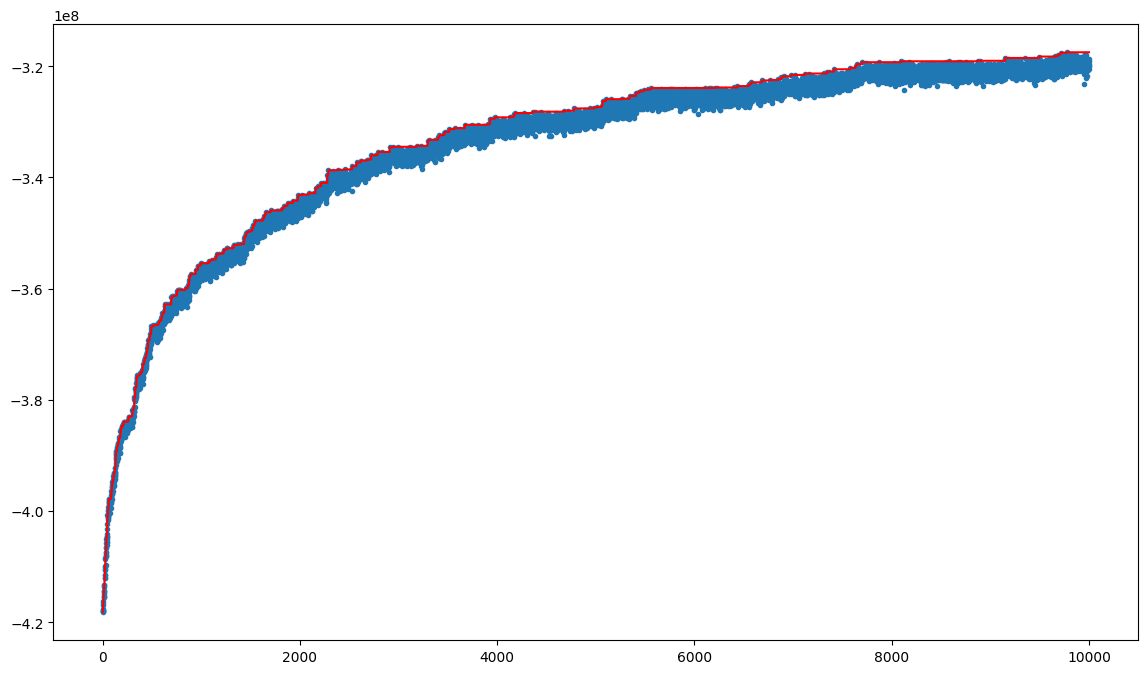

In [19]:
solution = rng.random(NUM_SETS) < .5 # start from a valid solution
ic(fitness(solution))
solution_fitness = fitness(solution)
history = [solution_fitness[1]]
tweak = multiple_mutation_tweak
for steps in tqdm(range(ITERATIONS)):
    new_solution = tweak(solution)
    new_fitness = fitness(new_solution)
    history.append(new_fitness[1])
    if new_fitness>solution_fitness:
        solution=new_solution
        solution_fitness = new_fitness
    
ic(fitness(solution))
plt.figure(figsize=(14, 8))
plt.plot(
    [max(history[: i + 1]) for i in range(len(history))],
    color="red",
)
plt.scatter(range(len(history)), history, marker=".");


### Simulated Annealing
Another option is to use a new variable temperature in order to accept worsening solution depening if the temperature is high or not.

In [36]:
def p_temp_swap(t,old_fitness,new_fitness):
    if new_fitness>old_fitness:
        return 1
    else:
        return np.exp(-(old_fitness-new_fitness)/t)

def random_temp_swap(t,old_fitness,new_fitness):
    return rng.random()<p_temp_swap(t,old_fitness,new_fitness)

In this case, i choose to model the temperature as exponentially decreasing: the parameter *alpha* is the actual base-constant of the exponential.

In [37]:
def simulate_annealing(T_start,iterations,alpha,*,tweakingFunction=single_mutation_tweak):
    temp = T_start


    tweak = tweakingFunction
    solution = rng.random(NUM_SETS) < .5 # start from a random solution
    best_solution = solution
    bs_fitness = fitness(best_solution)
    ic(fitness(solution))
    ic(temp)
    solution_fitness = fitness(solution)
    generated_history = np.array([solution_fitness[1]]) # history of proposed solutions (CAN BE INVALID)
    gh_validity = np.array([solution_fitness[0]])
    true_history = np.array([solution_fitness[1]]) # history of followed/adopted solutions (ALWAYS VALID)
    for k in tqdm(range(iterations)):
        new_solution = tweak(solution)
        new_fitness = fitness(new_solution)
        generated_history = np.append(generated_history,new_fitness[1])
        gh_validity = np.append(gh_validity,new_fitness[0])
        if new_fitness[0] and random_temp_swap(temp,solution_fitness[1],new_fitness[1]):
            solution=new_solution
            solution_fitness = new_fitness
            if solution_fitness>bs_fitness:
                best_solution = solution
                bs_fitness = solution_fitness
        true_history = np.append(true_history,solution_fitness[1])
        temp = temp*alpha
        
    ic(fitness(solution))
    ic(temp)
    plt.figure(figsize=(14, 8))
    plt.scatter(np.arange(len(generated_history))[gh_validity],generated_history[gh_validity], marker=".",label='Fitness of Valid Proposed Solutions')
    plt.scatter(np.arange(len(generated_history))[~gh_validity],generated_history[~gh_validity], marker=".",label='Fitness of Invalid Proposed Solutions', color="red")
    plt.plot(
        [max(generated_history[: i + 1]) for i in range(len(generated_history))],
        color="orange",
        label='Maximum Fitness of All Proposed Solutions'
    )
    plt.plot(
        true_history,
        color="lime",
        linewidth=0.6,
        label='Fitness of Accepted Solutions'
    )
    plt.legend()
    return (best_solution,bs_fitness);

Now, we define a function used to evaluate the result in a readable way:

In [38]:
def evaluate_solution(sol):
    indexes = np.where(sol[0])[0].tolist()
    print(f"Solution Obtained ({"VALID" if sol[1][0] else "INVALID"}):\nincludes indexes ({len(indexes)}) {indexes}\n Total Fitness = {float(sol[1][1])}\n")


Finally, i define all the parameters required by the model:

In [39]:
T_START = 500
ITERATIONS = 10_000
ALPHA = 0.999
TWEAKING_FUNCTION = single_mutation_tweak

ic| fitness(solution): (np.True_, np.float64(-422064833.9975877))
ic| temp: 500


  0%|          | 0/10000 [00:00<?, ?it/s]

ic| fitness(solution): (np.True_, np.float64(-155081626.28472456))
ic| temp: 0.022586672988524157


Solution Obtained (VALID):
includes indexes (1844) [2, 3, 14, 16, 20, 23, 31, 39, 43, 44, 47, 53, 55, 65, 67, 87, 89, 94, 95, 103, 105, 107, 109, 123, 124, 133, 137, 138, 140, 155, 159, 163, 170, 174, 180, 202, 232, 246, 261, 267, 269, 274, 278, 285, 296, 302, 314, 315, 319, 325, 327, 331, 337, 339, 342, 346, 362, 369, 370, 371, 372, 393, 395, 404, 405, 407, 410, 412, 422, 426, 427, 430, 440, 446, 453, 463, 472, 483, 486, 490, 492, 495, 498, 500, 508, 510, 511, 520, 524, 525, 527, 529, 533, 540, 544, 545, 546, 554, 564, 565, 566, 577, 580, 588, 593, 595, 597, 600, 610, 611, 638, 643, 658, 660, 663, 667, 674, 682, 685, 686, 694, 703, 710, 720, 722, 733, 735, 738, 748, 754, 755, 759, 763, 781, 782, 784, 787, 805, 819, 822, 827, 836, 846, 861, 871, 880, 887, 900, 903, 910, 913, 916, 921, 924, 927, 933, 934, 945, 962, 971, 972, 981, 984, 985, 989, 998, 1000, 1014, 1017, 1022, 1027, 1038, 1046, 1049, 1050, 1065, 1066, 1071, 1080, 1081, 1082, 1089, 1094, 1104, 1111, 1133, 1137, 1138, 1140, 1

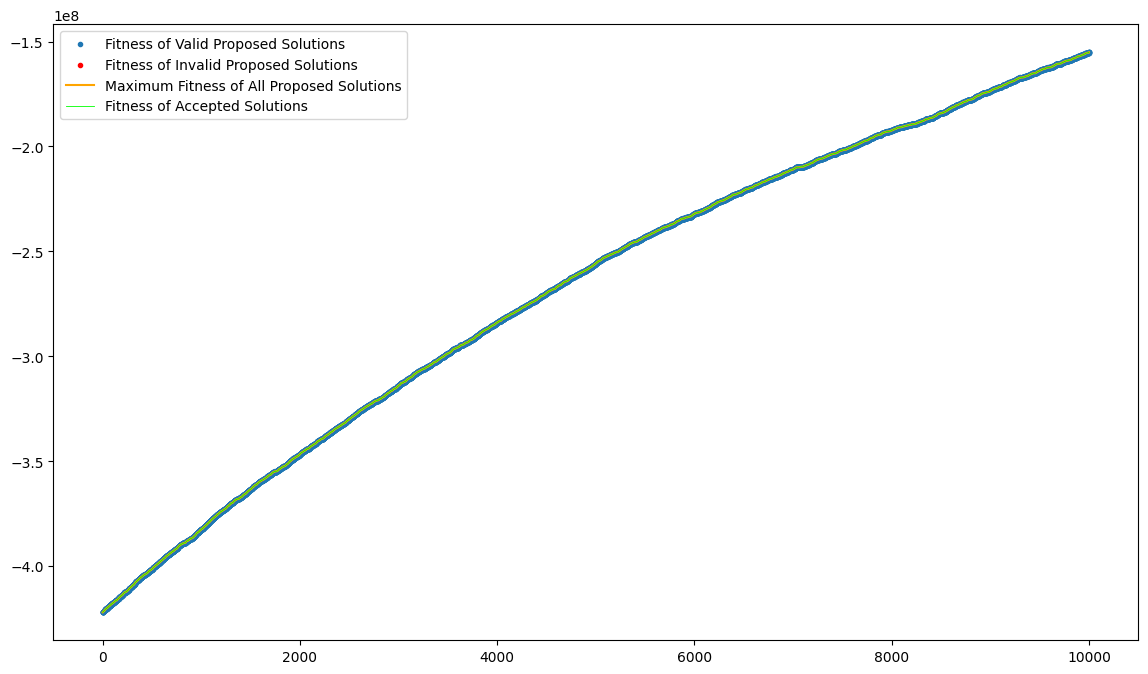

In [40]:
bs = simulate_annealing(T_START,ITERATIONS,ALPHA,tweakingFunction=TWEAKING_FUNCTION);
evaluate_solution(bs);

### Iterated Local Search
As we can see from the plot, the model focuses on **exploration** when the temperature is high, and as it cools down the model is more focused on **exploitation**.
This technique seems useful, but the risk is to remain stuck in a *plateau* or a *ridge* corresponding to a local maximum, as when the maximum is found much less exploration is done: this can be solved with **iterated local search**, by **restarting** the algorithm at certain points using the previous solutions as starting points. Therefore, i modified the previous function to use it in a repeatable way:

In [41]:
def simulate_annealing(T_start,iterations,alpha,*,tweakingFunction=single_mutation_tweak,repetitions=1):    
    
    temp = T_start
    tweak = tweakingFunction
    solution = rng.random(NUM_SETS) < .5 # start from a random solution
    best_solution = solution
    bs_fitness = fitness(best_solution)
    
    ic(fitness(solution))
    ic(temp)
    solution_fitness = fitness(solution)
    generated_history = np.array([solution_fitness[1]]) # history of proposed solutions (CAN BE INVALID)
    gh_validity = np.array([solution_fitness[0]])
    true_history = np.array([solution_fitness[1]]) # history of followed/adopted solutions (ALWAYS VALID)
    for r in tqdm(range(repetitions),position=0,desc="Restarts"):
        temp = T_start
        for k in tqdm(range(int(iterations/repetitions)),position=1):
            new_solution = tweak(solution)
            new_fitness = fitness(new_solution)
            generated_history = np.append(generated_history,new_fitness[1])
            gh_validity = np.append(gh_validity,new_fitness[0])
            if new_fitness[0] and random_temp_swap(temp,solution_fitness[1],new_fitness[1]):
                solution=new_solution
                solution_fitness = new_fitness
                if solution_fitness>bs_fitness:
                    best_solution = new_solution
                    bs_fitness = solution_fitness
            true_history = np.append(true_history,solution_fitness[1])
            temp = temp*alpha
        
    ic(fitness(solution))
    ic(temp)
    plt.figure(figsize=(14, 8))
    plt.scatter(np.arange(len(generated_history))[gh_validity],generated_history[gh_validity], marker=".",label='Fitness of Valid Proposed Solutions')
    plt.scatter(np.arange(len(generated_history))[~gh_validity],generated_history[~gh_validity], marker=".",label='Fitness of Invalid Proposed Solutions', color="red")
    plt.plot(
        [max(generated_history[: i + 1]) for i in range(len(generated_history))],
        color="orange",
        label='Maximum Fitness of All Proposed Solutions'
    )
    plt.plot(
        true_history,
        color="lime",
        linewidth=0.8,
        label='Fitness of Accepted Solutions'
    )
    plt.legend()
    return (best_solution,bs_fitness);

I define again all model parameters:

In [42]:
T_START = 100
ITERATIONS = 10_000
ALPHA = 0.999
TWEAKING_FUNCTION = multiple_mutation_tweak
REPETITIONS = 2

ic| fitness(solution): (np.True_, np.float64(-419427676.86033154))
ic| temp: 100


Restarts:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

ic| fitness(solution): (np.True_, np.float64(-317207714.20342755))
ic| temp: 0.6721111959865606


Solution Obtained (VALID):
includes indexes (3771) [0, 3, 5, 6, 8, 11, 13, 16, 20, 21, 24, 27, 30, 32, 33, 39, 40, 41, 42, 46, 48, 51, 52, 53, 54, 56, 59, 61, 64, 66, 69, 71, 73, 75, 77, 80, 82, 84, 86, 93, 98, 101, 102, 103, 109, 112, 113, 115, 117, 119, 121, 125, 127, 128, 131, 134, 135, 136, 137, 149, 151, 152, 158, 159, 162, 163, 168, 170, 172, 173, 175, 177, 183, 189, 190, 191, 192, 194, 195, 196, 200, 201, 202, 205, 206, 212, 214, 215, 216, 217, 218, 220, 224, 230, 232, 235, 236, 237, 238, 239, 240, 244, 246, 248, 251, 254, 257, 259, 260, 261, 262, 263, 264, 266, 268, 271, 272, 274, 275, 278, 281, 284, 288, 290, 293, 294, 297, 300, 306, 307, 310, 312, 313, 315, 316, 317, 319, 321, 322, 324, 325, 330, 335, 337, 339, 343, 344, 347, 349, 351, 352, 357, 358, 359, 360, 367, 371, 373, 375, 378, 381, 383, 386, 387, 392, 393, 394, 395, 399, 400, 402, 404, 405, 406, 407, 422, 423, 428, 434, 435, 439, 442, 450, 451, 456, 462, 469, 471, 475, 484, 485, 488, 491, 493, 495, 498, 504, 506, 508,

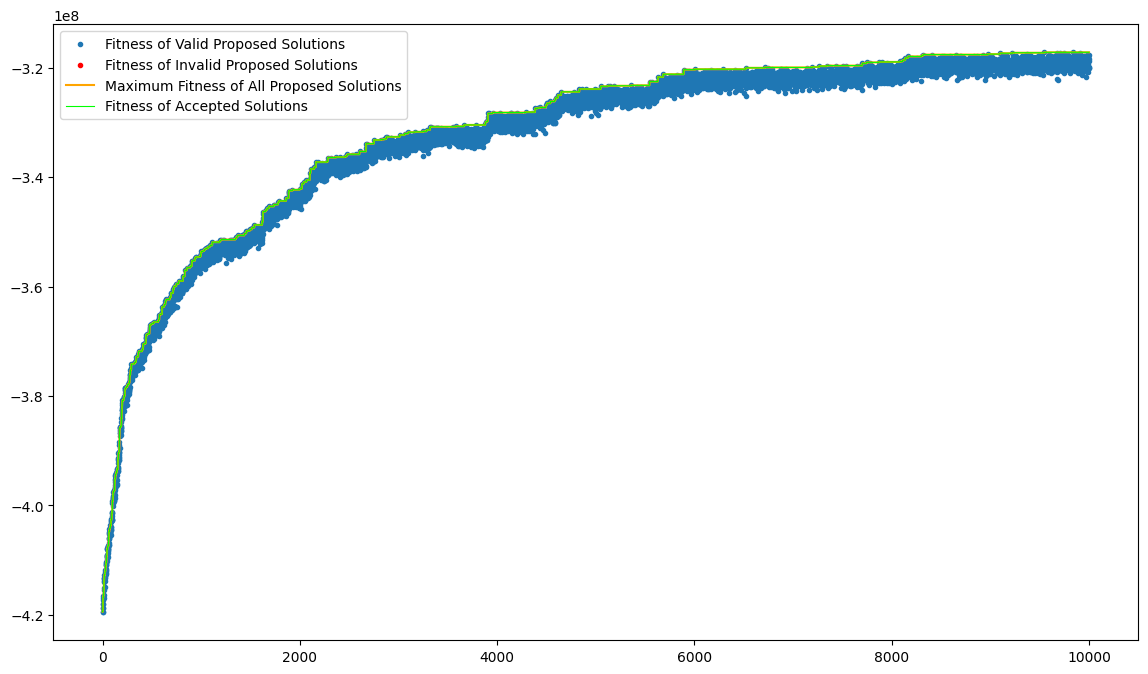

In [43]:
bs = simulate_annealing(T_START,ITERATIONS,ALPHA,repetitions=REPETITIONS,tweakingFunction=TWEAKING_FUNCTION)
evaluate_solution(bs);

### Self-Adapting Tweaking Function

Finally, in order to speed-up the climb to local maximums in the solution space, i added the possibility of having a self-adaptation of the number of multiple mutation of the tweaking function, making it **larger when the fitness is increasing**, in order to speed-up the climb, and **smaller when stationary points are found**. In this way, i tried to avoid the model to reduce the impact of restarts on the reach of local maximum.
I therefore re-define the multiple-mutation tweak function and the simulated anealing function:

In [44]:
def multiple_mutation_perc_tweak(sol: np.ndarray, *, perc:float=1) -> np.ndarray:
    """tweaks provided solution; perc reprent percentage of mutation a.k.a. mutation strenght"""
    frac = float(perc)/100
    mask = rng.random(NUM_SETS)<frac 
    if not np.any(mask):
        mask[np.random.randint(NUM_SETS)] = True
    new_sol = np.logical_xor(sol,mask)
    return new_sol

The strenght shouls be managed by the algorithm as an endogenous parameter, that is self-adaptive depending on last improvements. In my specific implementation, i thought that was a good idea to define the adaptation such that:
- it looks on last `100` tweakings generated, and find how many improvements are present there
- if it is more than a 1/5 the tweaking strenght increases by `5`, otherwise it decrease by `5`

In [54]:
def simulate_annealing_selfapt_tweak(T_start,iterations,alpha,*,repetitions=1): 
    LI_BUFFER_SIZE = 50

    tweak = multiple_mutation_perc_tweak   
    
    perc_strength = float(1)
    li_buffer = [] # last-improvements buffer -> shoul maintain max size LI_BUFFER_SIZE

    temp = T_start
    solution = rng.random(NUM_SETS) < .5 # start from a random solution
    best_solution = solution
    bs_fitness = fitness(best_solution)

    
    
    ic(fitness(solution))
    ic(temp)
    solution_fitness = fitness(solution)
    generated_history = np.array([solution_fitness[1]]) # history of proposed solutions (CAN BE INVALID)
    gh_validity = np.array([solution_fitness[0]])
    true_history = np.array([solution_fitness[1]]) # history of followed/adopted solutions (ALWAYS VALID)
    for r in tqdm(range(repetitions),position=0,desc="Restarts"):
        temp = T_start
        for k in tqdm(range(int(iterations/repetitions)),position=1):
            new_solution = tweak(solution,perc=perc_strength)
            new_fitness = fitness(new_solution)
            generated_history = np.append(generated_history,new_fitness[1])
            gh_validity = np.append(gh_validity,new_fitness[0])
            li_buffer.append(new_fitness>solution_fitness) # push new improvement into buffer
            li_buffer = li_buffer[-LI_BUFFER_SIZE:]
            if sum(li_buffer)>LI_BUFFER_SIZE/5:
                perc_strength = perc_strength+5 if perc_strength <= 95 else 99 # upper bound
            else:
                perc_strength = perc_strength-5 if perc_strength >= 5 else 1
            if new_fitness[0] and random_temp_swap(temp,solution_fitness[1],new_fitness[1]):
                solution=new_solution
                solution_fitness = new_fitness
                if solution_fitness>bs_fitness:
                    best_solution = solution
                    bs_fitness = solution_fitness
            true_history = np.append(true_history,solution_fitness[1])
            temp = temp*alpha
        
    ic(fitness(solution))
    ic(temp)
    plt.figure(figsize=(14, 8))
    plt.scatter(np.arange(len(generated_history))[gh_validity],generated_history[gh_validity], marker=".",label='Fitness of Valid Proposed Solutions')
    plt.scatter(np.arange(len(generated_history))[~gh_validity],generated_history[~gh_validity], marker=".",label='Fitness of Invalid Proposed Solutions', color="red")
    plt.plot(
        [max(generated_history[: i + 1]) for i in range(len(generated_history))],
        color="orange",
        label='Maximum Fitness of All Proposed Solutions'
    )
    plt.plot(
        true_history,
        color="lime",
        linewidth=0.8,
        label='Fitness of Accepted Solutions'
    )
    plt.legend()
    return (best_solution,bs_fitness);

I define again model parameters:

In [55]:
T_START = 100
ITERATIONS = 10_000
ALPHA = 0.999
REPETITIONS = 2

ic| fitness(solution): (np.True_, np.float64(-419994970.98172885))
ic| temp: 100


Restarts:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

ic| fitness(solution): (np.True_, np.float64(-157017458.73986608))
ic| temp: 0.6721111959865606


Solution Obtained (VALID):
includes indexes (1867) [0, 7, 19, 22, 34, 38, 40, 53, 56, 58, 67, 69, 73, 75, 77, 89, 95, 96, 97, 110, 111, 115, 117, 119, 136, 144, 145, 147, 149, 156, 162, 166, 167, 171, 177, 180, 185, 187, 191, 194, 202, 206, 224, 227, 232, 242, 243, 245, 250, 261, 272, 279, 287, 290, 292, 308, 313, 314, 318, 323, 327, 330, 347, 352, 358, 366, 367, 374, 378, 379, 381, 395, 398, 408, 415, 427, 430, 434, 435, 436, 444, 451, 464, 467, 470, 471, 475, 476, 493, 519, 521, 524, 525, 531, 533, 534, 539, 540, 547, 548, 552, 554, 557, 559, 562, 565, 566, 570, 571, 572, 576, 591, 601, 606, 615, 630, 635, 650, 651, 654, 670, 673, 677, 688, 689, 692, 695, 696, 700, 706, 708, 709, 710, 714, 715, 718, 729, 747, 751, 762, 766, 770, 771, 776, 778, 786, 798, 803, 808, 809, 811, 820, 826, 829, 832, 852, 854, 857, 859, 867, 870, 880, 883, 886, 889, 891, 896, 910, 915, 917, 921, 922, 925, 928, 933, 936, 940, 942, 943, 952, 968, 969, 972, 973, 977, 983, 990, 991, 1003, 1007, 1018, 1023, 1029,

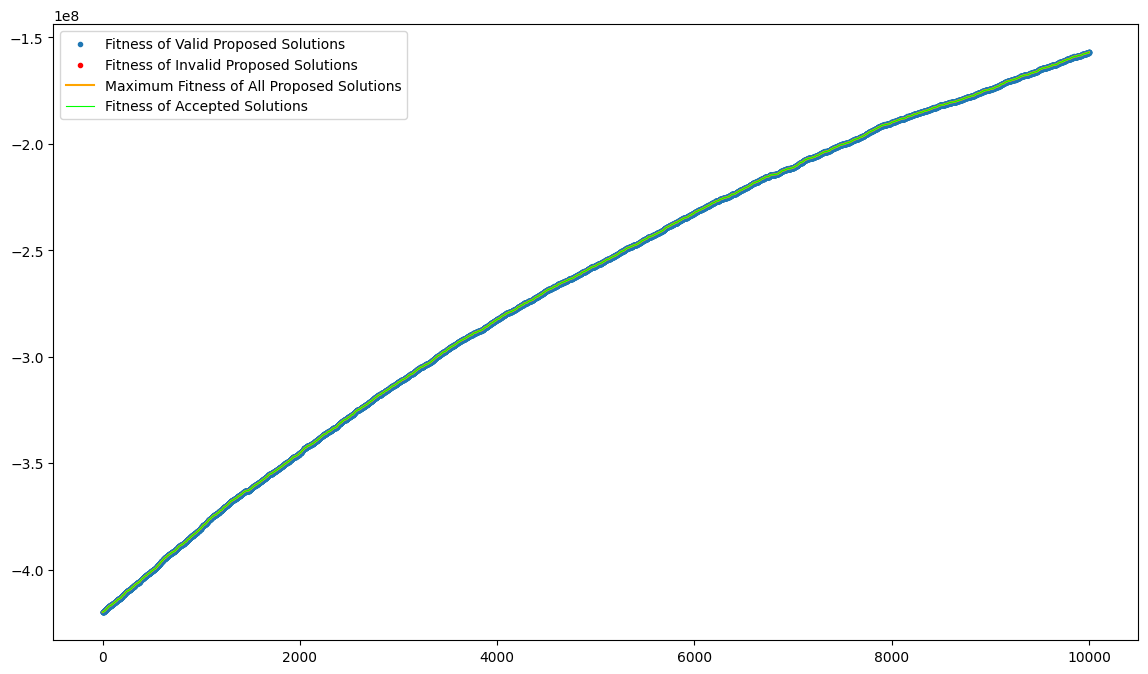

In [56]:
bs = simulate_annealing(T_START,ITERATIONS,ALPHA,repetitions=REPETITIONS)
evaluate_solution(bs);